**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources: Marco Peixeiro in www.towardsdatascience.com. Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

# Time Series Analysis: SKlearn


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = sm.datasets.co2.load_pandas().data

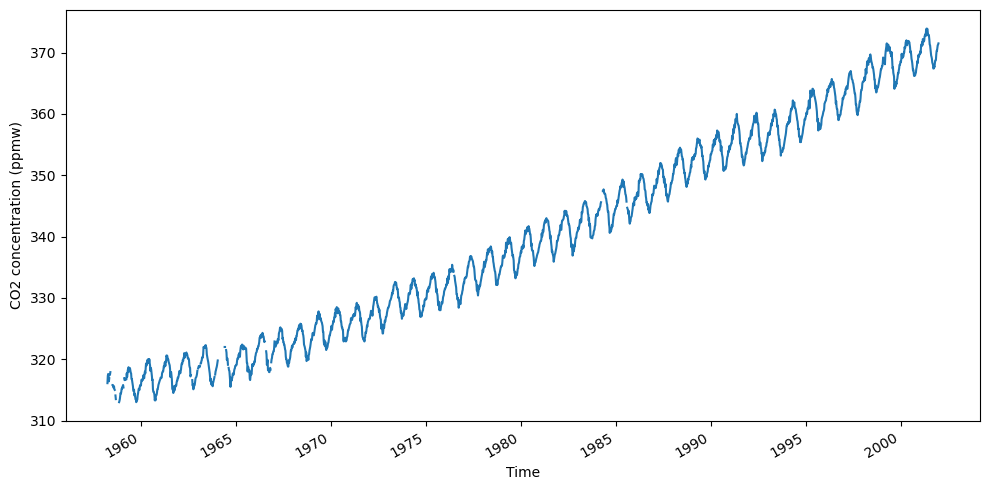

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')
fig.autofmt_xdate()
plt.tight_layout()

From the image above, we notice a clear positive trend in the data, as the concentration is increasing over time. We also observe a yearly seasonal pattern. This is due to the change of seasons, where CO2 concentration is higher during winter than during summer. Finally, we see some missing data at the beginning of the dataset.

Let’s then treat that missing data using interpolation. We will simply take a linear interpolation between two known points to fill the missing values.


In [6]:
data = data.interpolate()

the biggest challenge in forecasting time series with scikit-learn is in setting up the problem correctly. There are 3 different ways in which we can frame a time series forecasting problem as a supervised learning problem:

* Predict the next time step using the previous observation
* Predict the next time step using a sequence of past observations
* Predict a sequence of future time steps using a sequence of past observations

In [ ]:
## Predict the next time step using the previous observation

This is the most basic setup. The model outputs a prediction for the next time step, given only the previous observation. This is a simple use case with little practical applications, since a model is likely not going to learn anything from the previous observation only. However, it serves as a good starting point to help us understand the more complex scenarios later on.

Thus, we add a second column that simply shifts the co2 column such that the value in 1958–03–29 is now a predictor for the value in 1958–04–05.

In [8]:
df = data.copy()
df['y'] = df['co2'].shift(-1)
df

,co2,y
1958-03-29,316.1,317.3
1958-04-05,317.3,317.6
1958-04-12,317.6,317.5
1958-04-19,317.5,316.4
1958-04-26,316.4,316.9
...,...,...
2001-12-01,370.3,370.8
2001-12-08,370.8,371.2
2001-12-15,371.2,371.3
2001-12-22,371.3,371.5


Let’s separate our dataset into a training and test set, in order to run our models and evaluate them. Here, we use the last two years of data for the training set. Since we have weekly data, and there are 52 weeks in a year, it means that the last 104 samples are kept for the test set.

In [9]:
train = df[:-104]
test = df[-104:]
test = test.drop(test.tail(1).index) # Drop last row

Let’s apply a decision tree regressor. This model can be replaced by any model you want from the scikit-learn library! Note that we use a random state to ensure reproducibility.

In [10]:
from sklearn.tree import DecisionTreeRegressor
X_train = train['co2'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['co2'].values.reshape(-1,1)
# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)
# Fit the model
dt_reg.fit(X=X_train, y=y_train)
# Make predictions
dt_pred = dt_reg.predict(X_test)
# Assign predictions to a new column in test
test['dt_pred'] = dt_pred
test

Notice that we keep the modeling portion simple. We don’t perform any cross-validation or hyperparameter tuning, although those techniques can be applied here normally, just like in any other regression problem. Feel free to apply those techniques and see if you can get better performances.

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred
test

,co2,y,dt_pred,gbr_pred
2000-01-08,368.5,369.0,368.650000,368.556464
2000-01-15,369.0,369.8,368.500000,368.774435
2000-01-22,369.8,369.2,369.400000,369.512468
2000-01-29,369.2,369.1,369.100000,369.041813
2000-02-05,369.1,369.6,368.800000,368.774435
...,...,...,...,...
2001-11-24,370.3,370.3,370.533333,370.535661
2001-12-01,370.3,370.8,370.533333,370.535661
2001-12-08,370.8,371.2,370.800000,370.710834
2001-12-15,371.2,371.3,371.000000,371.049344


Here, we use the mean absolute percentage error (MAPE). It is an especially informative error metric, as it return a percentage, which is easy to interpret. Make sure to only apply it when you don’t have values close to 0, which is the case here. Unfortunately, MAPE is not implemented yet in scikit-learn, so we must define the function by hand.

In [14]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

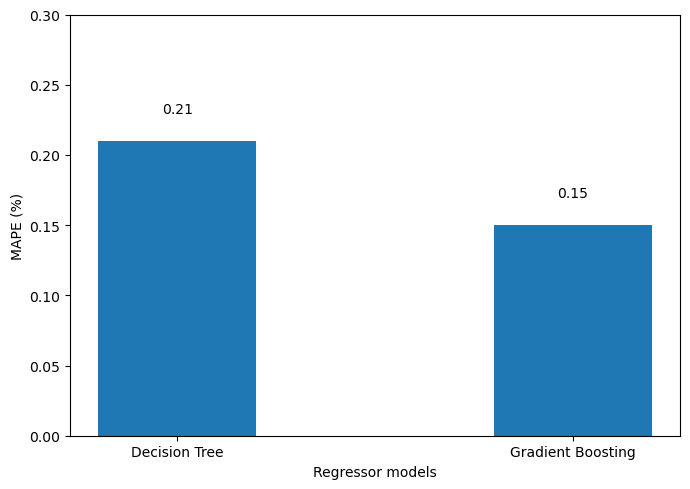

In [15]:
dt_mape = mape(test['y'], test['dt_pred'])
gbr_mape = mape(test['co2'], test['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Decision Tree', 'Gradient Boosting']
y = [dt_mape, gbr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 0.3)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

Looking at the figure above, we see that the baseline has the best performance, since it has the lowest MAPE. This makes sense as the CO2 concentration does not seem to change drastically from one week to another.

## Predict the next time step using a sequence of past observations

We must format our dataset such that we have a sequence of past observations acting as predictors to the following time step. We can easily write a function that adds shifted columns to get the desired input length.

In [16]:
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['co2'].shift(-i)
        i = i + 1
        
    if i == window_length:
        df['y'] = df['co2'].shift(-i)
        
    # Drop rows where there is a NaN
    df = df.dropna(axis=0)
        
    return df

Let’s use this function to have an input of 5 observations in order to predict the next time step.

In [17]:
new_df = window_input(5, data)
new_df

,co2,x_1,x_2,x_3,x_4,y
1958-03-29,316.1,317.3,317.6,317.5,316.4,316.90
1958-04-05,317.3,317.6,317.5,316.4,316.9,317.20
1958-04-12,317.6,317.5,316.4,316.9,317.2,317.50
1958-04-19,317.5,316.4,316.9,317.2,317.5,317.90
1958-04-26,316.4,316.9,317.2,317.5,317.9,317.55
...,...,...,...,...,...,...
2001-10-27,368.7,368.7,368.8,369.7,370.3,370.30
2001-11-03,368.7,368.8,369.7,370.3,370.3,370.80
2001-11-10,368.8,369.7,370.3,370.3,370.8,371.20
2001-11-17,369.7,370.3,370.3,370.8,371.2,371.30


Now, it is simply matter of applying different models and seeing which performs best. Before heading to that step, let’s first split our data into a training and a test set.

In [18]:
from sklearn.model_selection import train_test_split

X = new_df[['co2', 'x_1', 'x_2', 'x_3', 'x_4']].values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [19]:
dt_reg_5 = DecisionTreeRegressor(random_state=42)
dt_reg_5.fit(X_train, y_train)
dt_reg_5_pred = dt_reg_5.predict(X_test)

In [20]:
gbr_5 = GradientBoostingRegressor(random_state=42)
gbr_5.fit(X_train, y_train.ravel())
gbr_5_pred = gbr_5.predict(X_test)

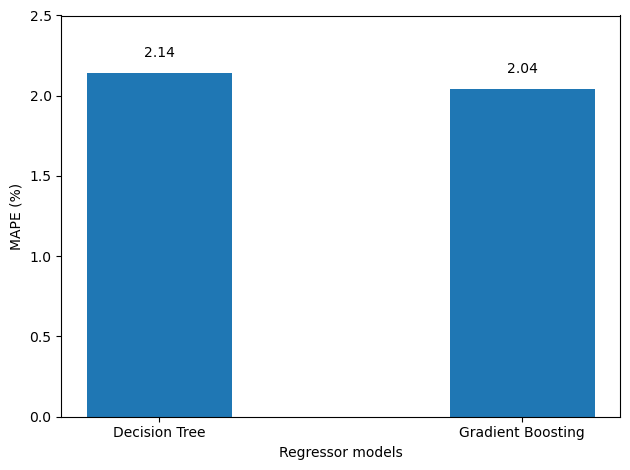

In [22]:
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Decision Tree', 'Gradient Boosting']
y = [dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

## Predict a sequence of future time steps using a sequence of past observations

The final scenario is using a sequence of observations to predict a sequence of future time steps, as shown below. Here, our model is required to output a sequence of predictions. This can be seen as a multi-output regression problem.

So, the first step is to format our dataset appropriately. We develop another function that uses the shift method to format the dataset as a multi-output regression problem.

In [23]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['co2'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['co2'].shift(-output_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df

Here, we will use a sequence of 26 observations to predict the next 26 time steps. In other words, we input half of a year to predict the next half. Note that the input and output sequences do not need to have the same length. This is an arbitrary decision on my end.

In [24]:
seq_df = window_input_output(26, 26, data)
seq_df

,co2,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25
1958-03-29,316.1,317.3,317.6,317.5,316.4,316.90,317.20,317.50,317.90,317.55,...,315.60,315.80,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.7
1958-04-05,317.3,317.6,317.5,316.4,316.9,317.20,317.50,317.90,317.55,317.20,...,315.80,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.7
1958-04-12,317.6,317.5,316.4,316.9,317.2,317.50,317.90,317.55,317.20,316.85,...,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.7
1958-04-19,317.5,316.4,316.9,317.2,317.5,317.90,317.55,317.20,316.85,316.50,...,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.70,317.1
1958-04-26,316.4,316.9,317.2,317.5,317.9,317.55,317.20,316.85,316.50,316.15,...,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.70,317.10,317.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-09,369.6,369.3,369.5,369.8,369.8,370.20,369.90,370.80,371.30,371.10,...,367.40,367.80,367.60,368.10,368.70,368.70,368.80,369.70,370.30,370.3
2000-12-16,369.3,369.5,369.8,369.8,370.2,369.90,370.80,371.30,371.10,371.70,...,367.80,367.60,368.10,368.70,368.70,368.80,369.70,370.30,370.30,370.8
2000-12-23,369.5,369.8,369.8,370.2,369.9,370.80,371.30,371.10,371.70,371.20,...,367.60,368.10,368.70,368.70,368.80,369.70,370.30,370.30,370.80,371.2
2000-12-30,369.8,369.8,370.2,369.9,370.8,371.30,371.10,371.70,371.20,372.20,...,368.10,368.70,368.70,368.80,369.70,370.30,370.30,370.80,371.20,371.3


As you can see, we now have a dataset where 26 observations are used as predictors for the next 26 time steps. Before moving on to modeling, again, we will split the data into a training and a test set. Here, we reserve the last two rows for the test set, as it gives us 52 test samples.

In [25]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]

X_cols.insert(0, 'co2')

y_cols = [col for col in seq_df.columns if col.startswith('y')]
X_train = seq_df[X_cols][:-2].values
y_train = seq_df[y_cols][:-2].values

X_test = seq_df[X_cols][-2:].values
y_test = seq_df[y_cols][-2:].values

In [26]:
dt_seq = DecisionTreeRegressor(random_state=42)
dt_seq.fit(X_train, y_train)
dt_seq_preds = dt_seq.predict(X_test)
dt_seq_preds

array([[372.9, 372.7, 372.1, 371.3, 371.2, 370.6, 369.9, 369.5, 369.3,
        369. , 368.4, 368.2, 368. , 367.4, 367.4, 367.8, 367.6, 368.1,
        368.7, 368.7, 368.8, 369.7, 370.3, 370.3, 370.8, 371.2],
       [372.9, 372.7, 372.1, 371.3, 371.2, 370.6, 369.9, 369.5, 369.3,
        369. , 368.4, 368.2, 368. , 367.4, 367.4, 367.8, 367.6, 368.1,
        368.7, 368.7, 368.8, 369.7, 370.3, 370.3, 370.8, 371.2]])

In [27]:
from sklearn.multioutput import RegressorChain
gbr_seq = GradientBoostingRegressor(random_state=42)
chained_gbr = RegressorChain(gbr_seq)
chained_gbr.fit(X_train, y_train)
gbr_seq_preds = chained_gbr.predict(X_test)
gbr_seq_preds

array([[372.91234321, 372.86820684, 372.61138382, 372.37008977,
        371.87095143, 371.47195088, 370.98161883, 370.43302093,
        370.13214216, 369.84316676, 369.49160888, 369.10391475,
        368.7412755 , 368.12299369, 368.1457326 , 368.2817398 ,
        368.42397489, 368.48255593, 368.52800057, 368.56197186,
        368.69919888, 368.73954859, 368.87105273, 369.55968265,
        370.03369346, 370.56943566],
       [372.86757507, 372.88205801, 372.58891692, 372.39556035,
        371.83484914, 371.45982952, 370.98245107, 370.44375112,
        370.13214216, 369.84316676, 369.43672539, 369.10391475,
        368.7412755 , 368.12299369, 368.1457326 , 368.2817398 ,
        368.38945877, 368.48255593, 368.52800057, 368.56197186,
        368.69919888, 368.73954859, 368.79783389, 369.66977982,
        370.1106187 , 370.56943566]])

This allowed to train the model and make predictions without encountering any errors. As I mentioned, behind the scenes, the model predicts the next time step, and uses that prediction to make the next prediction. The drawback of that method is that if the first prediction is bad, then the rest of the sequence is likely going to be bad.

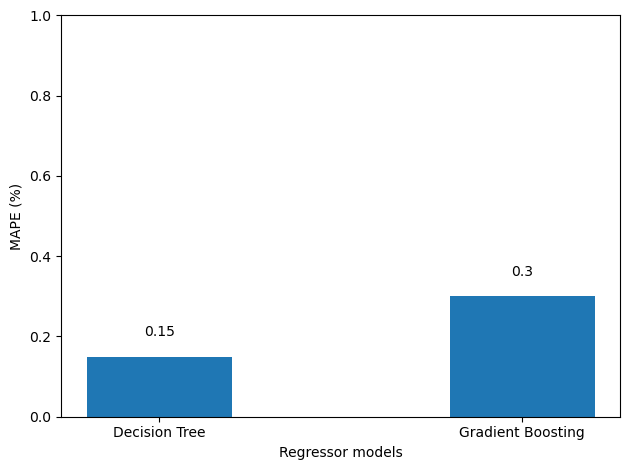

In [28]:
mape_dt_seq = mape(dt_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_gbr_seq = mape(gbr_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Decision Tree', 'Gradient Boosting']
y = [mape_dt_seq, mape_gbr_seq]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()

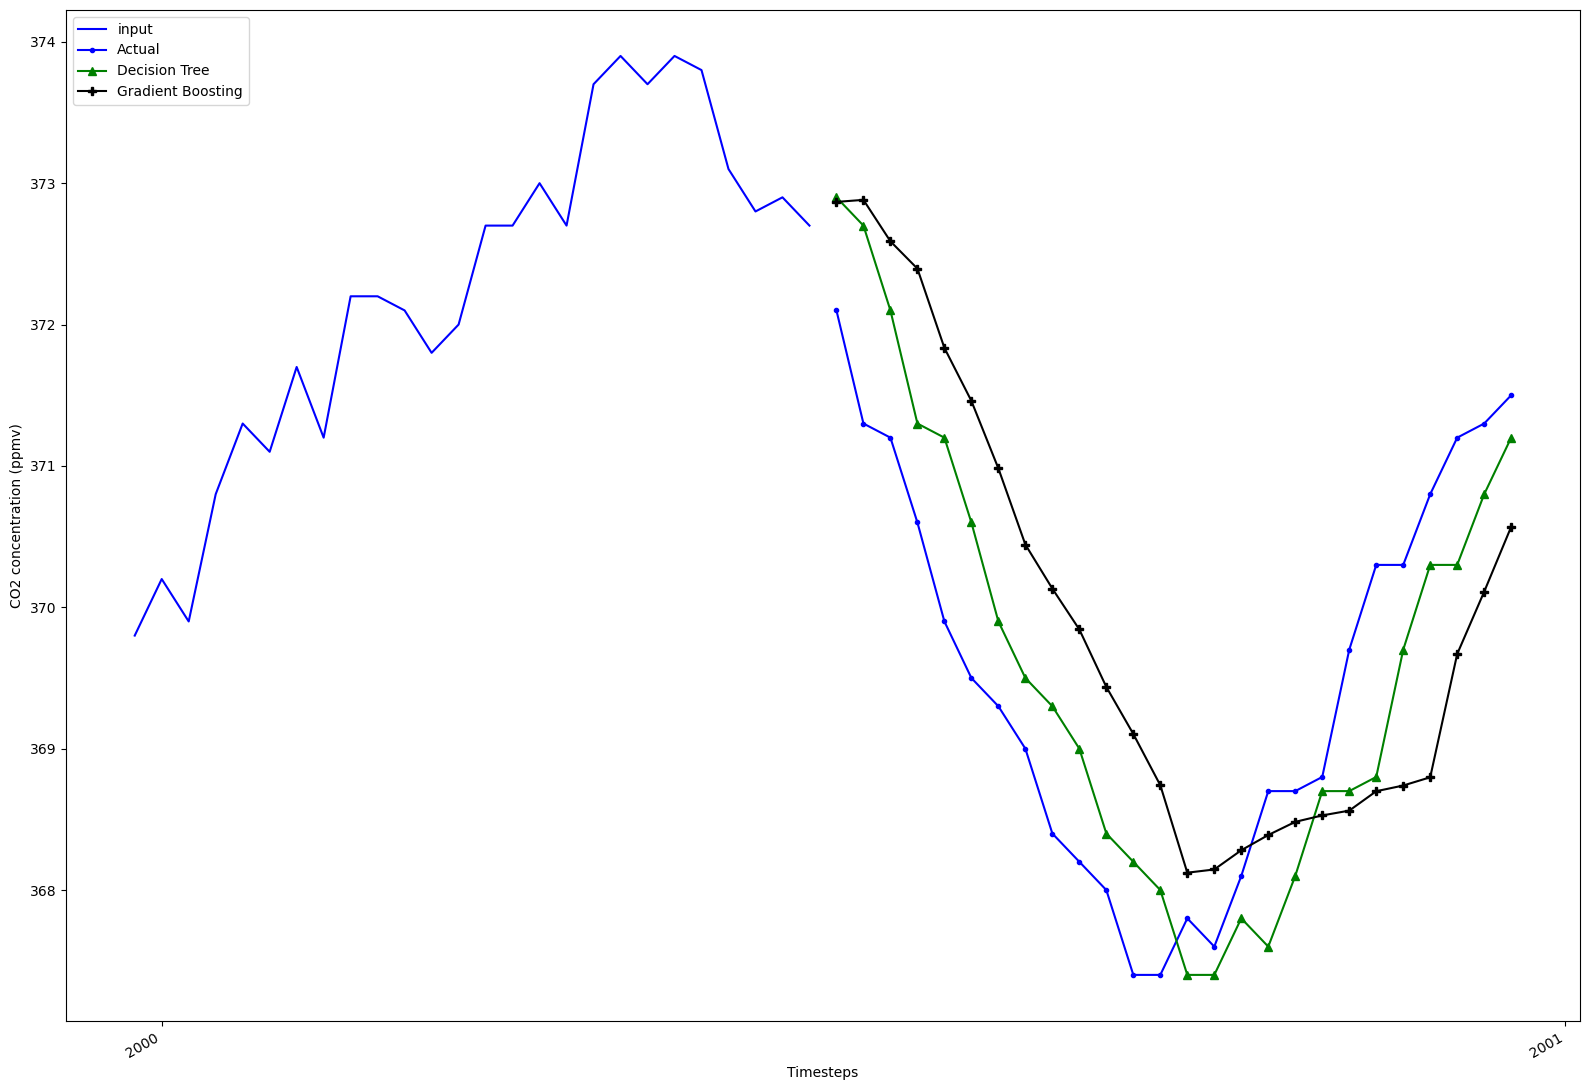

In [29]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(np.arange(0, 26, 1), X_test[1], 'b-', label='input')
ax.plot(np.arange(26, 52, 1), y_test[1], marker='.', color='blue', label='Actual')
ax.plot(np.arange(26, 52, 1), dt_seq_preds[1], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(26, 52, 1), gbr_seq_preds[1], marker='P', color='black', label='Gradient Boosting')
ax.set_xlabel('Timesteps')
ax.set_ylabel('CO2 concentration (ppmv)')
plt.xticks(np.arange(1, 104, 52), np.arange(2000, 2002, 1))
plt.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()